In [1]:
import os
import pandas as pd
import torch

from ls.data.icbhi_utils import (
    get_annotations,
    get_individual_cycles
)
from ls.data.preprocessing import cut_pad_waveform
from ls.data.icbhi import ICBHIDataset

In [2]:
from ls.config.loader import load_config

cfg = load_config("../configs/config.yaml")

print("Dataset config:", cfg.dataset)
print("Audio config:", cfg.audio)

Dataset config: {'name': 'icbhi', 'data_folder': '/Users/gkont/Downloads/Datasets/icbhi_dataset', 'class_split': 'lungsound', 'split_strategy': 'official', 'test_fold': 0, 'n_cls': 4, 'weighted_sampler': True, 'batch_size': 32, 'num_workers': 0, 'h': 128, 'w': 1024}
Audio config: {'sample_rate': 16000, 'desired_length': 10.0, 'pad_type': 'repeat', 'use_fade': True, 'fade_samples_ratio': 64, 'n_mels': 128, 'frame_length': 40, 'frame_shift': 10, 'low_freq': 0, 'high_freq': 8000, 'window_type': 'hanning', 'use_energy': False, 'dither': 0.0, 'mel_norm': 'hf', 'resz': 1.0, 'raw_augment': 1, 'wave_aug': [{'type': 'Crop', 'sampling_rate': 16000, 'zone': [0.0, 1.0], 'coverage': 1.0, 'p': 0.0}, {'type': 'Noise', 'color': 'white', 'p': 0.0}, {'type': 'Speed', 'factor': [0.9, 1.1], 'p': 0.0}, {'type': 'Loudness', 'factor': [0.5, 2.0], 'p': 0.1}, {'type': 'VTLP', 'sampling_rate': 16000, 'zone': [0.0, 1.0], 'fhi': 4800, 'factor': [0.9, 1.1], 'p': 0.1}, {'type': 'Pitch', 'sampling_rate': 16000, 'fac

In [4]:
# 1. Test annotations
annotations = get_annotations(cfg.dataset.data_folder, class_split="lungsound")

In [5]:
first_file, first_ann = next(iter(annotations.items()))
print(f"[Annotations] Loaded {len(annotations)} files. Example file: {first_file}")
print(first_ann.head())

[Annotations] Loaded 920 files. Example file: 148_1b1_Al_sc_Meditron
   Start    End  Crackles  Wheezes
0  0.022  0.364         0        0
1  0.364  2.436         0        0
2  2.436  4.636         0        0
3  4.636  6.793         0        0
4  6.793  8.750         0        0


In [6]:
# 2. Test cycle extraction
cycles = get_individual_cycles(
    first_ann,
    cfg.dataset,
    cfg.audio,
    first_file,
)
print(f"[Cycles] Extracted {len(cycles)} cycles for {first_file}")
print("Cycle tensor shape:", cycles[0][0].shape, " Label:", cycles[0][1])

[Cycles] Extracted 11 cycles for 148_1b1_Al_sc_Meditron
Cycle tensor shape: torch.Size([1, 5472])  Label: 0


/opt/homebrew/Caskroom/miniconda/base/envs/icbhi-ast/lib/python3.11/site-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(


In [ ]:
cycles[0][0]

(tensor([[-0.0750, -0.0724, -0.0706,  ..., -0.0315, -0.0314, -0.0309]]), 0)

In [11]:
processed = cut_pad_waveform(cycles[0][0], cfg.audio)
print("[Cut/Pad] Input shape:", cycles[0][0].shape, " -> Output shape:", processed.shape)

[Cut/Pad] Input shape: torch.Size([1, 5472])  -> Output shape: torch.Size([1, 160000])


In [12]:
processed.view(-1).shape

torch.Size([160000])

In [13]:
annotations["101_1b1_Al_sc_Meditron"]

,Start,End,Crackles,Wheezes
0,0.036,0.579,0,0
1,0.579,2.450,0,0
2,2.450,3.893,0,0
3,3.893,5.793,0,0
4,5.793,7.521,0,0
5,7.521,9.279,0,0
6,9.279,11.150,0,0
7,11.150,13.036,0,0
8,13.036,14.721,0,0
9,14.721,16.707,0,0


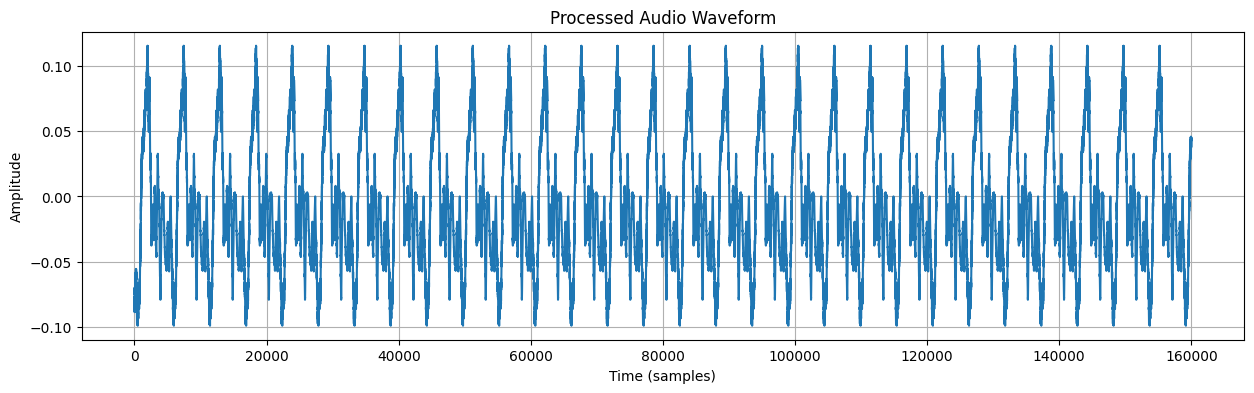

In [15]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 4))
plt.plot(processed[0].numpy())
plt.title("Processed Audio Waveform")
plt.xlabel("Time (samples)")
plt.ylabel("Amplitude")
plt.grid()
plt.show()

In [18]:
train_ds = ICBHIDataset(cfg.dataset, cfg.audio, train=True, print_info=True)

print(f"[Dataset] Length: {len(train_ds)} samples")

/opt/homebrew/Caskroom/miniconda/base/envs/icbhi-ast/lib/python3.11/site-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(


[ICBHI] Extracted 4142 respiratory cycles from 539 recordings
[ICBHI] Input spectrogram shape: (997, 128, 1)
[ICBHI] 4142 cycles (base cycles only, aug handled dynamically)
  Class 0: 2063 (49.8%)
  Class 1: 1215 (29.3%)
  Class 2: 501 (12.1%)
  Class 3: 363 (8.8%)
[ICBHI] Active waveform augmentations: Loudness, VTLP
[ICBHI] Active spectrogram augmentations: SpecAugment
[ICBHI] Expected P(augmented) ≈ 0.43 (~1793/4142 per epoch)
[Dataset] Length: 4142 samples


In [19]:
print(train_ds)

ICBHIDataset(train=True, n_samples=4142, input_shape=(997, 128), n_wave_augs=2, n_spec_augs=1)


In [21]:
from ls.data.transforms import generate_fbank

image = generate_fbank(processed, cfg.audio)
label = cycles[0][1]
print("FBank shape:", image.shape, " Label:", label)

FBank shape: torch.Size([997, 128, 1])  Label: 0


Sample image shape: torch.Size([997, 128, 1]), Sample audio shape: torch.Size([1, 160000]), Label: 0, from filename 148_1b1_Al_sc_Meditron


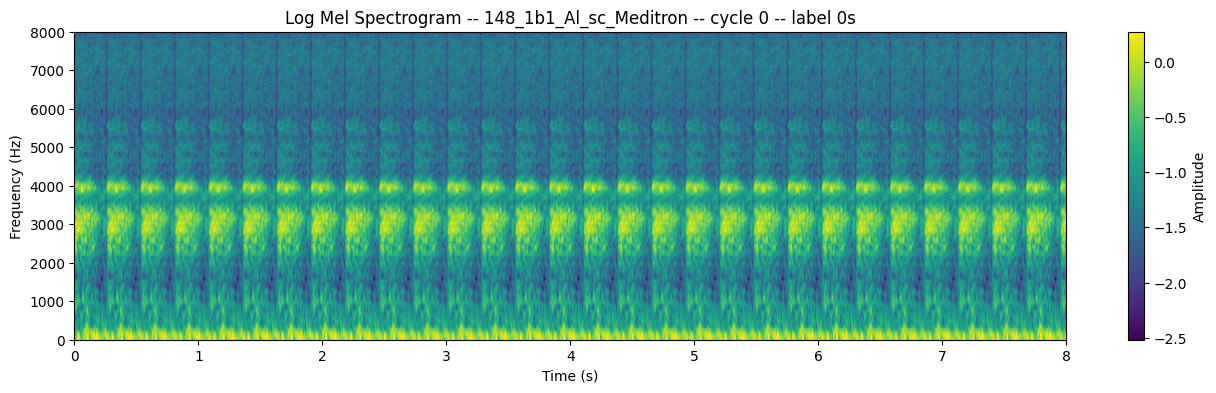

In [22]:
import numpy as np
import IPython.display as ipd

print(f"Sample image shape: {image.shape}, Sample audio shape: {processed.shape}, Label: {label}, from filename {first_file}")

# x_axis = np.arange(image.shape[0]) / 16000
freq_axis = np.linspace(0, 8000, image.shape[1])

plt.figure(figsize=(16, 4))
plt.imshow(image.squeeze(-1).T, aspect="auto", extent=[0, 8, 0, freq_axis[-1]], origin="lower")
plt.xlabel("Time (s)")
plt.ylabel("Frequency (Hz)")
# plt.xticks(x_axis[::1000])
# plt.yticks(np.arange(0, image.shape[1], step=16) * 8000 / 128)
plt.colorbar(label="Amplitude")
plt.title(f"Log Mel Spectrogram -- {first_file} -- cycle {0} -- label {label}s")
plt.show()

ipd.Audio(processed.numpy(), rate=16000)

In [23]:
from ls.data.augmentation import SpecAugment

In [26]:
image.shape

torch.Size([997, 128, 1])

In [30]:
# Instantiate SpecAugment with 'LB' policy and 'mean' masking
spec_augment = SpecAugment(policy='icbhi_ast_sup', mask='mean', p=0.5)

Augmented shape: torch.Size([1, 128, 997]), Type: <class 'torch.Tensor'>


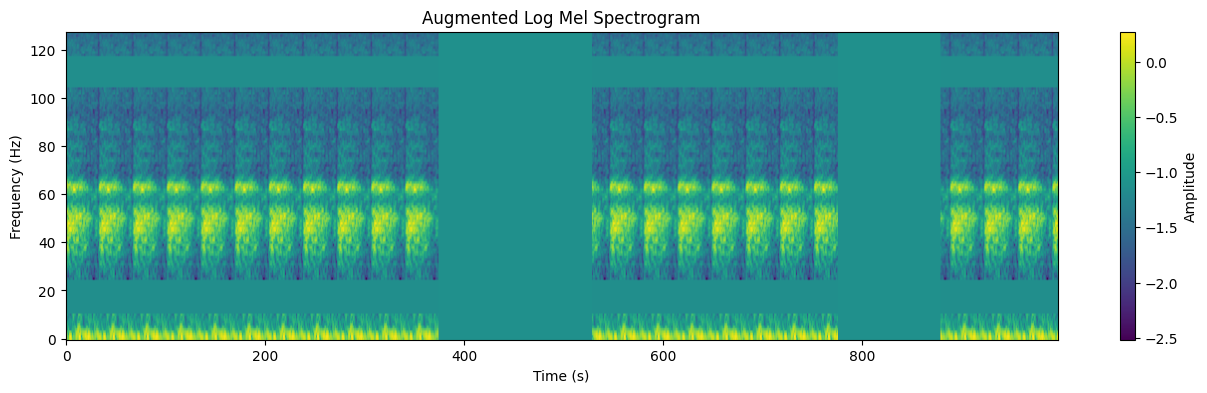

In [33]:
augmented_log_mel_spec = spec_augment(image.permute(2, 1, 0))
print(f"Augmented shape: {augmented_log_mel_spec.shape}, Type: {type(augmented_log_mel_spec)}")
# Display the augmented spectrogram
plt.figure(figsize=(16, 4))
plt.imshow(augmented_log_mel_spec.squeeze(0), aspect='auto', origin='lower')
plt.title("Augmented Log Mel Spectrogram")
plt.xlabel("Time (s)")
plt.ylabel("Frequency (Hz)")
plt.colorbar(label="Amplitude")
plt.show()